In [74]:
dependencies = ["mesa", "numpy", "pandas"]

In [75]:
import importlib
import subprocess
import sys

def install_and_import(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed")
    except ImportError:
        print(f"{package} is not installed, installing now...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")

for package in dependencies:
    install_and_import(package)

mesa is already installed
numpy is already installed
pandas is already installed


In [76]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random
MAXVAL = 10000
random.seed(67890)
np.random.seed(67890)

In [77]:
#Nombre: Diego Reséndiz Fernández
#Matricula: A01708017
#Fecha de creacion: 16/05/2024
#Ultima fecha de modificación: 16/05/2024
#Sinopsis:

In [78]:
#Nombre: AgenteRobot
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear agentes de tipo caja

In [79]:
class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [80]:

class AgenteRobot(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.totalMoves = 0
    self.carryingBox = False
    self.targetPosition = None
    self.currentTarget = None
    self.targetPositions = []



  def updatePileList(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    for neighbor in neighbors:
      cellContents = self.model.grid.get_cell_list_contents(neighbor)
      numBoxes = sum(1 for agent in cellContents if isinstance(agent, Box))
      if 0 < numBoxes < 5:
        if neighbor not in self.targetPositions:
          self.targetPositions.append(neighbor)
      elif numBoxes >= 5:
        if neighbor in self.targetPositions:
          self.targetPositions.remove(neighbor)

  def moveTowardsTarget(self):
    currentX, currentY = self.pos
    targetX, targetY = self.targetPosition
    # Calcular la dirección del movimiento
    dx = targetX - currentX
    dy = targetY - currentY
    # Determinar el paso de movimiento en x y y
    stepX = 1 if dx > 0 else -1 if dx < 0 else 0
    stepY = 1 if dy > 0 else -1 if dy < 0 else 0
    # Crear una lista de posibles movimientos
    possibleMoves = []
    if stepX != 0:
      possibleMoves.append((currentX + stepX, currentY))
    if stepY != 0:
      possibleMoves.append((currentX, currentY + stepY))
        # Filtrar los movimientos posibles para mantener solo los vacíos
    possibleMoves = [move for move in possibleMoves if self.model.grid.is_cell_empty(move)]
    if possibleMoves:
      # Elegir el movimiento más cercano al objetivo
      moveToTarget = min(possibleMoves, key=lambda pos: self.model.grid.get_distance(pos, self.targetPosition))
      self.model.grid.move_agent(self, moveToTarget)
      self.totalMoves += 1
    else:
      # Si no hay movimientos posibles, quedarse en el mismo lugar
      self.targetPosition = None

  def move(self):
   if self.currentTarget and self.carryingBox:
     self.moveTowardsTarget()
   else:
     self.randomMove()


  def chooseTarget(self):
    if self.targetPositions:
        self.currentTarget = self.targetPositions.pop(0)  # Elegir el objetivo más cercano
    else:
        self.currentTarget = None


  def randomMove(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    emptyNeighbors = [neighbor for neighbor in neighbors if self.model.grid.is_cell_empty(neighbor)]
    if emptyNeighbors:
      if self.carryingBox and self.targetPosition:
        if self.pos == self.targetPosition:
          self.placeBox(self.pos)
          self.targetPosition = None
        else:
          newPosition = self.random.choice(emptyNeighbors)
          self.model.grid.move_agent(self, newPosition)
          self.totalMoves += 1
      else:
        newPosition = self.random.choice(emptyNeighbors)
        self.model.grid.move_agent(self, newPosition)
        self.totalMoves += 1

  def placeBox(self, pos):
    newBox = Box(self.model.next_id(), self.model)
    self.model.grid.place_agent(newBox, pos)
    self.carryingBox = False
    print(f'El agente {self.unique_id} colocó una caja en {pos}')

  def pickBox(self, pos):
    cellContents = self.model.grid.get_cell_list_contents(pos)
    for agent in cellContents:
      if isinstance(agent, Box):
        self.model.grid.remove_agent(agent)
        self.carryingBox = True
        print(f'El agente {self.unique_id} removio una caja en {pos}')
        return

  def search(self):
    neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    for neighbor in neighbors:
      cellContents = self.model.grid.get_cell_list_contents(neighbor)
      numBoxes = sum(1 for agent in cellContents if isinstance(agent, Box))
      if numBoxes > 0:
        if self.carryingBox and numBoxes <= 4:
          self.placeBox(neighbor)
          return
        elif not self.carryingBox:
          if numBoxes < 3:
            self.pickBox(neighbor)
            return
        elif numBoxes >= 3:
          self.targetPosition = neighbor
          return


  def step(self):
    self.updatePileList()
    self.search()
    self.move()


In [81]:
#Nombre: getGrid
#Parametros: un model.
#Return: Nada
#Se encarga de crear una representación visual del estado actual de la cuadrícula en el modelo
def getGrid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if not model.grid.is_cell_empty((x, y)):
                contents = model.grid.get_cell_list_contents((x, y))
                if any(isinstance(agent, Box) for agent in contents):
                    grid[x][y] = 1  # Asignar 1 si hay una caja en la celda
                elif any(isinstance(agent, AgenteRobot) for agent in contents):
                  for agent in contents:
                    if agent.carryingBox:
                      grid[x][y] = 4  # Asignar 4 si hay un agente robot en la celda
                    else:
                      grid[x][y] = 2  # Asignar 2 si hay un agente robot en la celda y no tiene una caja
            else:
                grid[x][y] = 0  # Celda vacía
    return grid

In [82]:
class WarehouseModel(Model):
  def __init__(self, width, height, num_agents, num_boxes):
    super().__init__()
    self.cells = np.zeros((width, height))
    self.numAgents = num_agents
    self.numBoxes = num_boxes
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.currentStep = 0
    self.pileCount = 0
    self.maxBoxesPerPile = 5


    #Colocamos las cajas
    boxId = 0
    while self.numBoxes > 0:
      numBoxesInGroup = random.randint(1, 3)
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      # Verificar el número de cajas en la celda
      cellContents = self.grid.get_cell_list_contents((x, y))
      numBoxesInCell = sum(1 for agent in cellContents if isinstance(agent, Box))
      # Ajustar el grupo de cajas si es mayor que las cajas restantes
      if numBoxesInGroup > self.numBoxes:
        numBoxesInGroup = self.numBoxes
        # Si al agregar el grupo de cajas no se excede el máximo, colocarlas
        if numBoxesInCell + numBoxesInGroup <= 5:
          for i in range(numBoxesInGroup):
            newBox = Box(boxId, self)
            self.grid.place_agent(newBox, (x, y))
            boxId += 1
          self.numBoxes -= numBoxesInGroup
        else:
           # Colocar solo el número de cajas que faltan para llegar al máximo de 5
           remainingSpace = 5 - numBoxesInCell
           for i in range(remainingSpace):
            newBox = Box(boxId, self)
            self.grid.place_agent(newBox, (x, y))
            boxId += 1
           self.numBoxes -= remainingSpace
      else:
        # Si al agregar el grupo de cajas no se excede el máximo, colocarlas
        if numBoxesInCell + numBoxesInGroup <= 5:
          for i in range(numBoxesInGroup):
            newBox = Box(boxId, self)
            self.grid.place_agent(newBox, (x, y))
            boxId += 1
          self.numBoxes -= numBoxesInGroup
        else:
          # Colocar solo el número de cajas que faltan para llegar al máximo de 5
          remainingSpace = 5 - numBoxesInCell
          for i in range(remainingSpace):
            newBox = Box(boxId, self)
            self.grid.place_agent(newBox, (x, y))
            boxId += 1
          self.numBoxes -= remainingSpace

      print(f'Cajas restantes: {self.numBoxes}')


    for i in range(self.numAgents):
      emptyPositions = self.grid.empties
      if emptyPositions:
        position = self.random.choice(list(emptyPositions))
        agent = AgenteRobot(i, self)
        self.grid.place_agent(agent, position)
        self.schedule.add(agent)

  def countPiles(self):
    count = 0
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        contents = self.grid.get_cell_list_contents((x, y))
        numBoxes = sum(1 for agent in contents if isinstance(agent, Box))
        if numBoxes == self.maxBoxesPerPile:
          count += 1
    self.pileCount = count

  def allBoxesStacked(self):
    self.countPiles()
    return self.pileCount == 40

  def countTotalBoxes(self):
    totalBoxes = 0
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        contents = self.grid.get_cell_list_contents((x, y))
        totalBoxes += sum(1 for agent in contents if isinstance(agent, Box))
    return totalBoxes

  def step(self):
    self.dataCollector.collect(self)
    self.schedule.step()
    self.countPiles()
    self.currentStep += 1
    #if self.all_boxes_stacked():
     # self.running = False


In [83]:

#Se encarga de llevar acabo las iteraciones, es decir el step, es donde se lleva acabo la simulacion
GRIDSIZE = 20

MAXITER = 500

AGENTNUM = 5

NUMBOXES = 200

startTime = time.time()

model = WarehouseModel(GRIDSIZE, GRIDSIZE, AGENTNUM, NUMBOXES)

i=1
while i < MAXITER:
  model.step()
  i = i + 1

Cajas restantes: 199
Cajas restantes: 197
Cajas restantes: 194
Cajas restantes: 192
Cajas restantes: 189
Cajas restantes: 188
Cajas restantes: 185
Cajas restantes: 182
Cajas restantes: 180
Cajas restantes: 178
Cajas restantes: 176
Cajas restantes: 174
Cajas restantes: 172
Cajas restantes: 171
Cajas restantes: 170
Cajas restantes: 167
Cajas restantes: 165
Cajas restantes: 164
Cajas restantes: 162
Cajas restantes: 159
Cajas restantes: 158
Cajas restantes: 157
Cajas restantes: 156
Cajas restantes: 154
Cajas restantes: 153
Cajas restantes: 152
Cajas restantes: 149
Cajas restantes: 146
Cajas restantes: 143
Cajas restantes: 141
Cajas restantes: 138
Cajas restantes: 135
Cajas restantes: 133
Cajas restantes: 131
Cajas restantes: 130
Cajas restantes: 127
Cajas restantes: 124
Cajas restantes: 122
Cajas restantes: 121
Cajas restantes: 118
Cajas restantes: 116
Cajas restantes: 114
Cajas restantes: 113
Cajas restantes: 111
Cajas restantes: 108
Cajas restantes: 107
Cajas restantes: 105
Cajas restant

In [84]:
print('Valores de comprobacion')
model.countTotalBoxes()


Valores de comprobacion


199

In [85]:
#Obtenemos la informacion requerida para el analsis.
all_grid = model.dataCollector.get_model_vars_dataframe()
print(all_grid)

                                                  Grid
0    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
..                                                 ...
494  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
495  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
496  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
497  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
498  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

[499 rows x 1 columns]


Listo


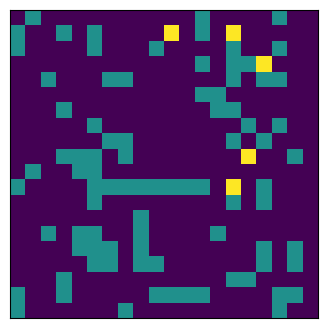

In [86]:
#Obtenemos la informacion en cada step y la graficamos para despues juntarla en una animacion
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])

if not all_grid.empty:
  print("Listo")
  patch = plt.imshow(all_grid.iloc[0][0], cmap='viridis')
else:
  print("no :C")
  patch = plt.imshow(np.zeros((model.grid.width, model.grid.height)), cmap='viridis')

def animate(i):
  if i < len(all_grid):
    patch.set_data(all_grid.iloc[i][0])
  else:
    patch.set_data(all_grid.iloc[-1][0])  # Muestra el último estado disponible

anim = animation.FuncAnimation(fig, animate, frames=MAXITER, repeat=False)
plt.show()

In [87]:
#Llamamos la animacion
anim

In [88]:
#Despliege de los datos importantes.
totalTime = time.time() - startTime
print('Tiempo de ejecucion : %.5f segundos' % totalTime)
#print(f'Tiempo necesario hasta que todas las celdas estén limpias: {model.timeNeeded} Steps')
print(f'pilas de 5 cajas al término de la simulación: {model.pileCount}')
#print(f'Número de movimientos realizados por todos los agentes: {model.totalMoves}')

Tiempo de ejecucion : 18.38667 segundos
pilas de 5 cajas al término de la simulación: 19
